In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


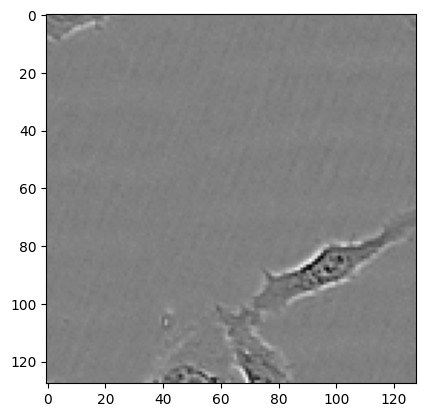

In [3]:
#!unzip counting-cells-in-microscopy-images-2024.zip # esc+b
#npzfile = np.load('train_data.npz')
npzfile = np.load('/content/drive/MyDrive/counting-cells-in-microscopy-images-2024/train_data.npz')
X_labeled = npzfile['X']
y_labeled = npzfile['y']

npzfile_test = np.load('/content/drive/MyDrive/counting-cells-in-microscopy-images-2024/test_images.npz')
X_test = npzfile_test['X']

i = 0 # change this value to view different images
#plt.imshow(X_labeled[i]/255 + .5*y_labeled[i], cmap='gray')
plt.imshow(X_test[i], cmap='gray')

In [4]:
X_train, X_val, y_train, y_val = sk.model_selection.train_test_split(X_labeled, y_labeled, train_size = .8)

In [5]:
# PyTorch wants us to create a dataset class.
# We need one dataset class for labeled data,
# and a different dataset class for test data,
# because the getitem methods will work differently in each case.
class DigitsDataset():
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, i):

    x = self.X[i] / 255.0
    y = self.y[i]
    x = x.reshape((1, 128, 128))
    y = y.reshape((1, 128, 128))
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return x, y

  def __len__(self):
    return len(self.X)

class DigitsDatasetTest():
  def __init__(self, X):
    self.X = X

  def __getitem__(self, i):

    x = self.X[i] / 255.0
    x = x.reshape((1, 128, 128))
    x = torch.tensor(x, dtype=torch.float32)

    return x

  def __len__(self):
    return len(self.X)

In [6]:
# dataset objects
dataset_train = DigitsDataset(X_train, y_train)
dataset_val = DigitsDataset(X_val, y_val)
dataset_test = DigitsDatasetTest(X_test)


# data loader objects
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 16, shuffle = True) # grabs a batch of data; sweep over the training data
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 16, shuffle = False) # no need shuffle cux no use in nueral network.
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 16, shuffle = False)

In [7]:

x_batch, y_batch = next(iter(dataloader_train))

In [8]:
# class SimpleCNN(torch.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding='same')
#     self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same')
#     self.dense1 = torch.nn.Linear(64*14*14, 10) # nulticlass is 10

#     self.relu = torch.nn.ReLU()
#     self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

#   def forward(self, x):

#     x = self.conv1(x) # output has shape (32, 28, 28)
#     x = self.relu(x)
#     x = self.maxpool(x) # x now has shape (32, 14, 14)

#     x = self.conv2(x) # x now has shape (64, 14, 14)
#     x = self.relu(x)

    # x = torch.flatten(x, start_dim=1) # x now has dimension 64*14*14
#     x = self.dense1(x)

#     return x

class UNet(torch.nn.Module):
  def __init__(self):
    super().__init__()
    # maxpooling
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3, padding='same')
    self.conv2 = torch.nn.Conv2d(64, 64, kernel_size=3, padding='same')

    self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding='same')
    self.conv4 = torch.nn.Conv2d(128, 128, kernel_size=3, padding='same')

    self.conv5 = torch.nn.Conv2d(128, 256, kernel_size=3, padding='same')
    self.conv6 = torch.nn.Conv2d(256, 256, kernel_size=3, padding='same')

    self.conv7 = torch.nn.Conv2d(256, 512, kernel_size=3, padding='same')
    self.conv8 = torch.nn.Conv2d(512, 512, kernel_size=3, padding='same')

    self.conv9 = torch.nn.Conv2d(512, 1024, kernel_size=3, padding='same')
    self.conv10 = torch.nn.Conv2d(1024, 1024, kernel_size=3, padding='same')

    # up sampling + conv

    self.conv11 = torch.nn.Conv2d(1024, 512, kernel_size=3, padding='same')
    self.conv12 = torch.nn.Conv2d(1024, 512, kernel_size=3, padding='same')
    self.conv13 = torch.nn.Conv2d(512, 512, kernel_size=3, padding='same')

    self.conv14 = torch.nn.Conv2d(512, 256, kernel_size=3, padding='same')
    self.conv15 = torch.nn.Conv2d(512, 256, kernel_size=3, padding='same')
    self.conv16 = torch.nn.Conv2d(256, 256, kernel_size=3, padding='same')

    self.conv17 = torch.nn.Conv2d(256, 128, kernel_size=3, padding='same')
    self.conv18 = torch.nn.Conv2d(256, 128, kernel_size=3, padding='same')
    self.conv19 = torch.nn.Conv2d(128, 128, kernel_size=3, padding='same')

    self.conv20 = torch.nn.Conv2d(128, 64, kernel_size=3, padding='same')
    self.conv21 = torch.nn.Conv2d(128, 64, kernel_size=3, padding='same')
    self.conv22 = torch.nn.Conv2d(64, 64, kernel_size=3, padding='same')

    self.conv23 = torch.nn.Conv2d(64, 1, kernel_size=3, padding='same')

    self.relu = torch.nn.ReLU()
    self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
    self.upsample = torch.nn.Upsample(scale_factor=2)

  def forward(self, x):

    x = self.conv1(x) # now x has shape (64, 128, 128)
    x = self.relu(x)
    x = self.conv2(x) # now x has shape (64, 128, 128)
    x1 = self.relu(x)
    x = self.maxpool(x1) # now x has shape (64, 64, 64)

    x = self.conv3(x) # now x has shape (128, 64, 64)
    x = self.relu(x)
    x = self.conv4(x) # now x has shape (128, 64, 64)
    x2 = self.relu(x)
    x = self.maxpool(x2) # now x has shape (128, 32, 32)

    x = self.conv5(x) # now x has shape (256, 32, 32)
    x = self.relu(x)
    x = self.conv6(x) # now x has shape (256, 32, 32)
    x3 = self.relu(x)
    x = self.maxpool(x3) # now x has shape (256, 16, 16)

    x = self.conv7(x) # now x has shape (512, 16, 16)
    x = self.relu(x)
    x = self.conv8(x) # now x has shape (512, 16, 16)
    x4 = self.relu(x)
    x = self.maxpool(x4) # now x has shape (512, 8, 8)

    x = self.conv9(x) # now x has shape (1024, 8, 8)
    x = self.relu(x)
    x = self.conv10(x) # now x has shape (1024, 8, 8)
    x = self.relu(x)

    # up sampling + conv

    x = self.upsample(x) # now x has shape (1024, 16, 16);  up sample + conv
    x = self.conv11(x) # now x has shape (512, 16, 16)
    x = self.relu(x)
    x = torch.cat((x4, x), 1) #  now x has shape (1024, 16, 16)
    x = self.conv12(x) # now x has shape (512, 16, 16)
    x = self.relu(x)
    x = self.conv13(x) # now x has shape (512, 16, 16)
    x = self.relu(x)

    x = self.upsample(x) # now x has shape (512, 32, 32)
    x = self.conv14(x) # now x has shape (256, 32, 32)
    x = self.relu(x) # Should this be here?
    x = torch.cat((x3, x), 1) # now x has shape (512, 32, 32)
    x = self.conv15(x) # now x has shape (256, 32, 32)
    x = self.relu(x)
    x = self.conv16(x) # now x has shape (256, 32, 32)
    x = self.relu(x)

    x = self.upsample(x) # now x has shape (256, 64, 64)
    x = self.conv17(x) # now x has shape (128, 32, 32)
    x = self.relu(x) # Should this be here?
    x = torch.cat((x2, x), 1) #  now x has shape (256, 64, 64)
    x = self.conv18(x) # now x has shape (128, 32, 32)
    x = self.relu(x)
    x = self.conv19(x) # now x has shape (128, 32, 32)
    x = self.relu(x)

    x = self.upsample(x) # now x has shape (128, 64, 64)
    x = self.conv20(x) # now x has shape (64, 64, 64)
    x = self.relu(x) # Should this be here?
    x = torch.cat((x1, x), 1) #  now x has shape (128, 64, 64)
    x = self.conv21(x) # now x has shape (64, 64, 64)
    x = self.relu(x)
    x = self.conv22(x) # now x has shape (64, 64, 64)
    x = self.relu(x)

    x = self.conv23(x)

    return x





In [9]:
model = UNet()
device = torch.device('cuda')
# device = torch.device('cpu')
model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
loss_fun = torch.nn.BCEWithLogitsLoss()

In [10]:
x_batch, y_batch = next(iter(dataloader_train))

In [11]:
x_batch, y_batch = next(iter(dataloader_train))
x_batch = x_batch.to(device)
y_pred = model(x_batch)

In [13]:
num_epochs = 155
ace_vals_train = []
ace_vals_val = []

for ep in range(num_epochs):
  print(f'ep is: {ep}')
  for x_batch, y_batch in dataloader_train:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    outputs = model(x_batch)
    loss = loss_fun(outputs, y_batch)
    model.zero_grad()
    loss.backward()
    optimizer.step()

  with torch.no_grad():
    ace = 0
    for x_batch, y_batch in dataloader_train:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(x_batch)
      loss = loss_fun(outputs, y_batch)
      ace = ace + loss * len(y_batch)

    ace = ace / len(dataset_train)
    ace = ace.item()
    ace_vals_train.append(ace)
    print(f'Avg. cross-entropy (training): {ace}')

    ace = 0
    for x_batch, y_batch in dataloader_val:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      outputs = model(x_batch)
      loss = loss_fun(outputs, y_batch)
      ace = ace + loss * len(y_batch)

    ace = ace / len(dataset_val)
    ace = ace.item()
    ace_vals_val.append(ace)
    print(f'Avg. cross-entropy (validation): {ace}')

ep is: 0
Avg. cross-entropy (training): 0.19285207986831665
Avg. cross-entropy (validation): 0.19449111819267273
ep is: 1
Avg. cross-entropy (training): 0.1714617908000946
Avg. cross-entropy (validation): 0.17354165017604828
ep is: 2
Avg. cross-entropy (training): 0.1599469929933548
Avg. cross-entropy (validation): 0.16243579983711243
ep is: 3
Avg. cross-entropy (training): 0.15222330391407013
Avg. cross-entropy (validation): 0.15598691999912262
ep is: 4
Avg. cross-entropy (training): 0.14376579225063324
Avg. cross-entropy (validation): 0.1481570303440094
ep is: 5
Avg. cross-entropy (training): 0.14247912168502808
Avg. cross-entropy (validation): 0.14683416485786438
ep is: 6
Avg. cross-entropy (training): 0.13995681703090668
Avg. cross-entropy (validation): 0.14554789662361145
ep is: 7
Avg. cross-entropy (training): 0.13224726915359497
Avg. cross-entropy (validation): 0.13909406960010529
ep is: 8
Avg. cross-entropy (training): 0.1276950091123581
Avg. cross-entropy (validation): 0.13577

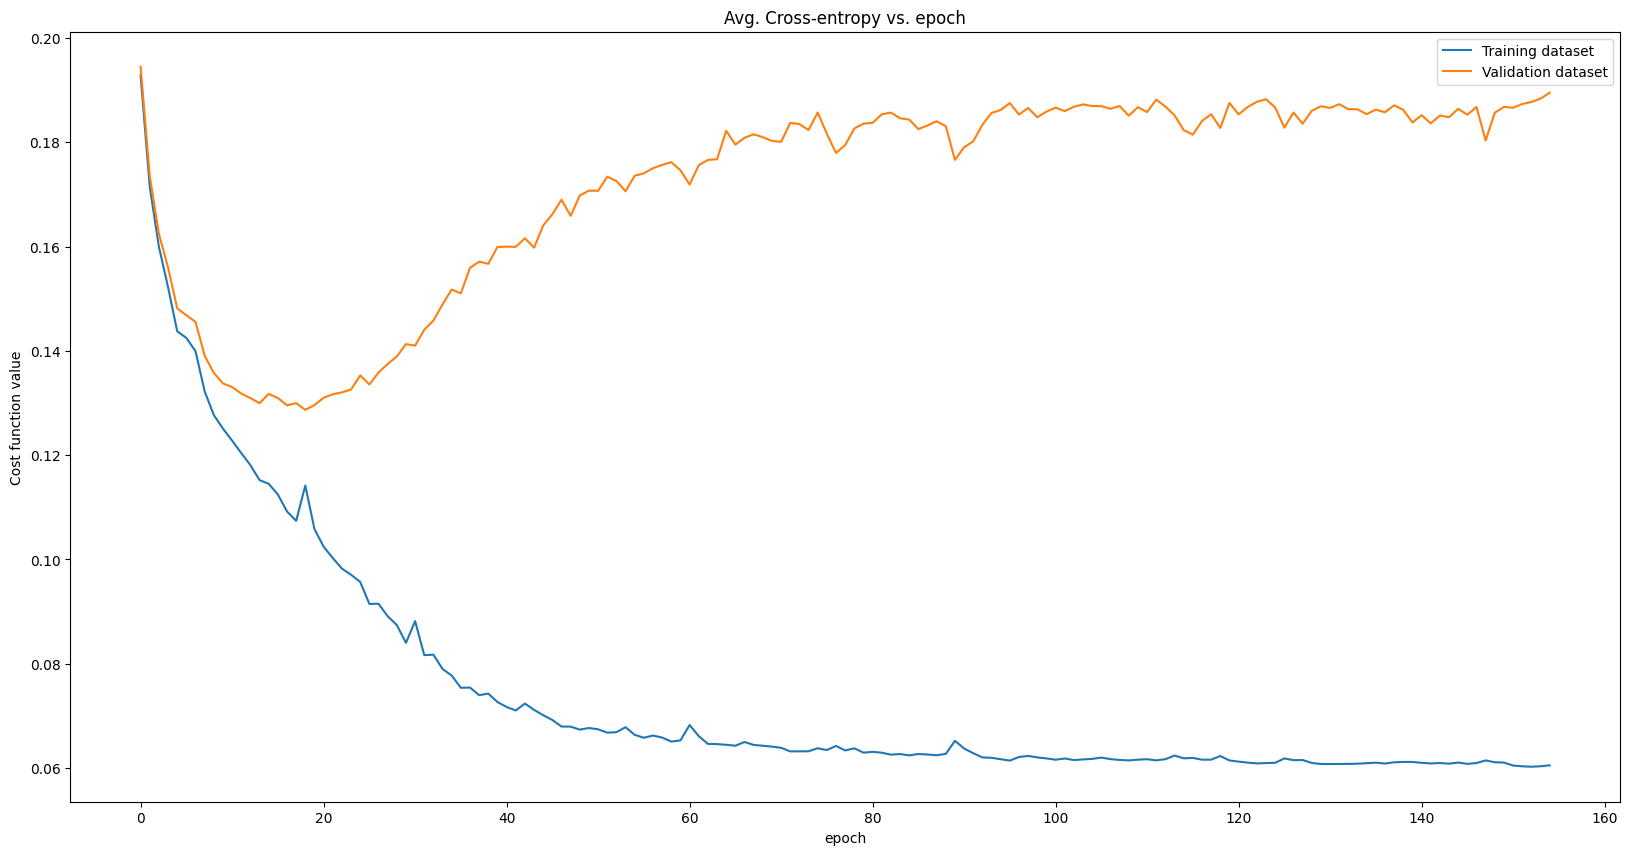

In [36]:
# We should always make a plot to check that the optimization algorithm
# succeeded in minimizing the avg. cross-entropy cost function.
plt.figure(figsize=(20, 10))
plt.plot(ace_vals_train, label="Training dataset")
plt.plot(ace_vals_val, label="Validation dataset")
plt.xlabel('epoch')
plt.ylabel('Cost function value')
plt.title('Avg. Cross-entropy vs. epoch')
plt.legend()

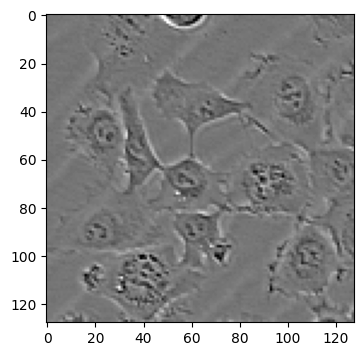

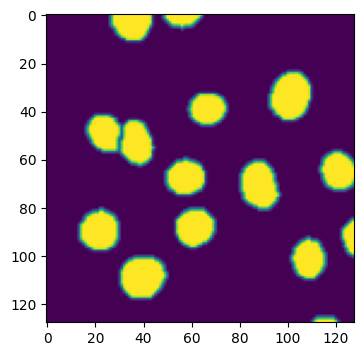

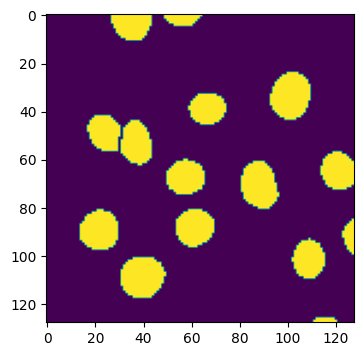

In [15]:
# Let's grab a batch of data then display a randomly selected
# image and predicted label from that batch.
x_batch, y_batch = next(iter(dataloader_train))
x_batch = x_batch.to(device)
with torch.no_grad():
  y_pred = model(x_batch)
sigmoid = torch.nn.Sigmoid()
probabilities = sigmoid(y_pred) # Why are the probabilities all 1?
predicted_labels =  torch.round(probabilities)# "dim=1" means take argmax for each row of probabilities


i = np.random.randint(16)
xi = x_batch[i].cpu()
yi = y_batch[i][0]
yi_pred = y_pred[i][0].cpu()
yi_prob = probabilities[i][0].cpu()
labels_pred = predicted_labels[i].cpu()
plt.figure(figsize=(4,4))
plt.imshow(xi.reshape((128, 128)), cmap='gray')
plt.figure(figsize=(4,4))
plt.imshow(yi)
plt.figure(figsize=(4,4))
plt.imshow(labels_pred[0])
# img2: ground truth
# img3: hard truth (when its adjacent to each other, it might be connected.)

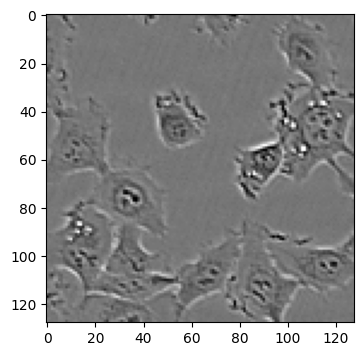

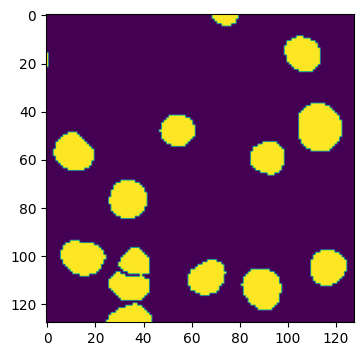

In [16]:
# Let's grab a batch of data then display a randomly selected
# image and predicted label from that batch.
x_batch = next(iter(dataloader_test))
x_batch = x_batch.to(device)
with torch.no_grad():
  y_pred = model(x_batch)
sigmoid = torch.nn.Sigmoid()
probabilities = sigmoid(y_pred) # Why are the probabilities all 1?
predicted_labels =  torch.round(probabilities)


i = np.random.randint(16)
xi = x_batch[i].cpu()

yi_pred = y_pred[i][0].cpu()
yi_prob = probabilities[i][0].cpu()
labels_pred = predicted_labels[i].cpu()
plt.figure(figsize=(4,4))
plt.imshow(xi.reshape((128, 128)), cmap='gray')

plt.figure(figsize=(4,4))
plt.imshow(labels_pred[0])
# img2: ground truth
# img3: hard truth (when its adjacent to each other, it might be connected.)

In [17]:
X_test.shape

(2000, 128, 128)

In [18]:
# Now we need to use our trained neural network
# to make predictions for each image in the test dataset
# and then create a Kaggle submission.
# Kaggle gives us a file called sample_submission.csv
# that shows us the format our Kaggle submission should have.

import cv2
import pdb
sigmoid = torch.nn.Sigmoid()
predicted_cell_counts = []

break_outer = False
img_idx = 0
batch_idx = 0
with torch.no_grad():
  for x_batch in dataloader_test:

    # pdb.set_trace()
    x_batch = x_batch.to(device)
    y_pred = model(x_batch)
    probabilities = sigmoid(y_pred)
    labels = torch.round(probabilities).cpu().numpy()

    for i in range(len(labels)):
      img = labels[i][0]
      img = np.uint8(img)
      #plt.imshow(img)
      #plt.show()  # Show the image
      info = cv2.connectedComponents(img) # round first
      num_components = info[0] - 1 # background included so gotta -1.
      predicted_cell_counts.append(num_components)
      #print(f'img_idx is: {img_idx} and num_components is: {num_components}')
      img_idx += 1
      if batch_idx == 14 and i==10 and False:
        plt.figure()
        plt.imshow(img)
        print(f'num_components is: {num_components}')
        break_outer = True

        break

    if break_outer:
      break
    batch_idx += 1


  # predicted_labels = predicted_labels + labels.tolist()



In [19]:
# plt.figure()
# plt.imshow(X_test[1945], cmap='gray')

In [20]:
num_components

37

In [21]:
N_test = len(predicted_cell_counts)
idxs = [i for i in range(N_test)]
dct = {'index': idxs, 'count':predicted_cell_counts}

kaggle_sub = pd.DataFrame(dct)
kaggle_sub.to_csv('./MyKaggleSubmission3.csv', index=False)

In [22]:
kaggle_sub.head()

,index,count
0,0,4
1,1,12
2,2,8
3,3,11
4,4,11


In [23]:
# loss function: Binary classification of spam or no spam emails/ dogs vs cats
# binary cross entropy cross function: p is fixed.

absolute error is: 1


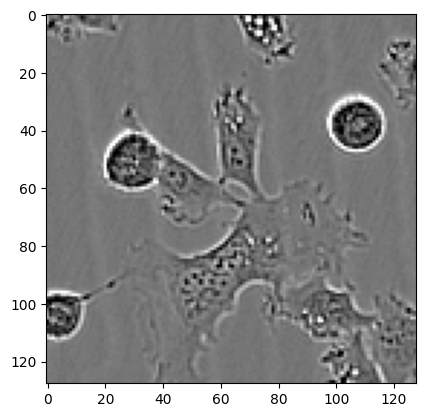

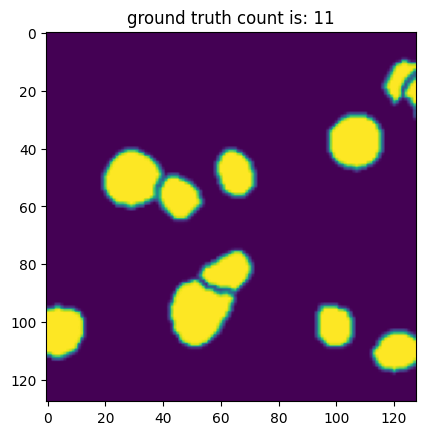

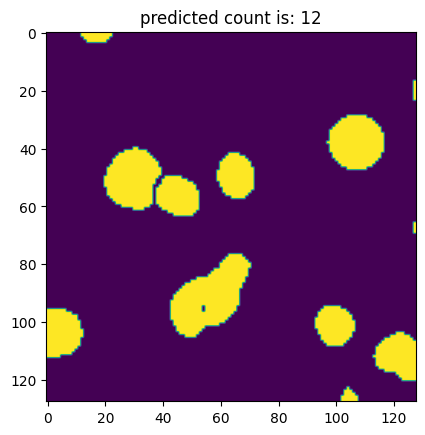

In [24]:

batch_count = 0
for x_batch, y_batch in dataloader_val:
  batch_count += 1

  if batch_count == 20:
    x_batch = x_batch.to(device)
    outputs = model(x_batch)
    probs = sigmoid(outputs)

    i = np.random.randint(len(x_batch))
    img = x_batch[i][0].cpu().numpy()
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.figure()
    labels = np.uint8(np.round(y_batch[i][0]))
    info = cv2.connectedComponents(labels)
    count = info[0] - 1
    plt.imshow(y_batch[i][0])
    plt.title(f'ground truth count is: {count}')

    labels_pred = np.round(probs[i][0].cpu().detach().numpy()).astype('uint8')
    info = cv2.connectedComponents(labels_pred)
    count_pred = info[0] - 1
    plt.figure()
    plt.imshow(labels_pred)
    plt.title(f'predicted count is: {count_pred}')

    print(f'absolute error is: {np.abs(count - count_pred)}')



In [25]:
# As a debugging step, let's try computing error in cell counts using the validation dataset.

import cv2
sigmoid = torch.nn.Sigmoid()
predicted_cell_counts = []
true_cell_counts = []

break_outer = False
img_idx = 0
batch_idx = 0
with torch.no_grad():
  for x_batch, y_batch in dataloader_val:
    x_batch = x_batch.to(device)
    y_pred = model(x_batch)
    probabilities = sigmoid(y_pred)
    labels = torch.round(probabilities).cpu().numpy()

    for i in range(len(labels)):
      target = torch.round(y_batch[i][0]).numpy().astype('uint8')
      info = cv2.connectedComponents(target)
      num_components_true = info[0] - 1
      true_cell_counts.append(num_components_true)


      img = labels[i][0]
      img = np.uint8(img)
      #plt.imshow(img)
      #plt.show()  # Show the image
      info = cv2.connectedComponents(img) # round first
      num_components = info[0] - 1 # background included so gotta -1.
      predicted_cell_counts.append(num_components)
      #print(f'img_idx is: {img_idx} and num_components is: {num_components}')
      img_idx += 1
      if batch_idx == 15 and i==10 and False:
        #plt.figure()
        #plt.imshow(img)
        #print(f'num_components is: {num_components}')
        break_outer = True

        break

    if break_outer:
      break
    batch_idx += 1

predicted_cell_counts = np.array(predicted_cell_counts)
true_cell_counts = np.array(true_cell_counts)
mae = np.mean(np.abs(predicted_cell_counts - true_cell_counts))
print(f'mae is: {mae}')

  # predicted_labels = predicted_labels + labels.tolist()



mae is: 1.4875


In [26]:
print(true_cell_counts[0:10])
print(predicted_cell_counts[0:10])

[15 16 23 11 18 29 33 16 12 13]
[15 16 19 12 19 28 30 18 12 16]


In [27]:
true_cell_counts = []
predicted_cell_counts = []
with torch.no_grad():
  for x_batch, y_batch in dataloader_val:
    x_batch = x_batch.to(device)
    y_pred = model(x_batch)
    probabilities = sigmoid(y_pred)
    labels = torch.round(probabilities).cpu().numpy()

    for i in range(len(labels)):
      target = torch.round(y_batch[i][0]).numpy().astype('uint8')
      info = cv2.connectedComponents(target)
      num_components_true = info[0] - 1
      true_cell_counts.append(num_components_true)


      img = labels[i][0]
      img = np.uint8(img)
      #plt.imshow(img)
      #plt.show()  # Show the image
      info = cv2.connectedComponents(img) # round first
      num_components = info[0] - 1 # background included so gotta -1.
      predicted_cell_counts.append(num_components)
      print(f'img_idx is: {img_idx} and num_components is: {num_components}')
      img_idx += 1
      break
    break

img_idx is: 400 and num_components is: 15


In [28]:
predicted_cell_counts

[15]

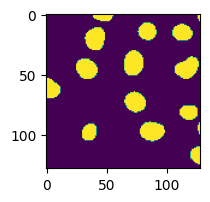

In [29]:
plt.figure(figsize=(2,2))
plt.imshow(labels[0][0])

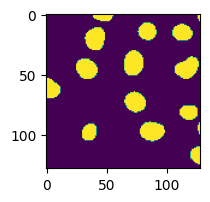

In [30]:
plt.figure(figsize=(2,2))
plt.imshow(labels[0][0])

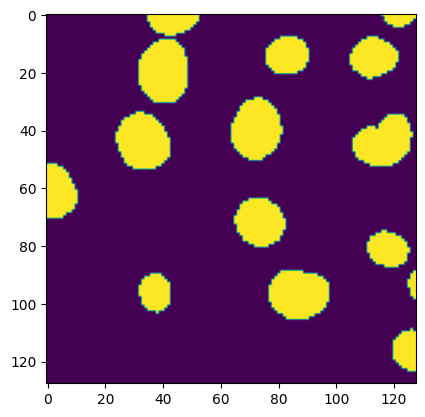

In [31]:
plt.imshow(target)

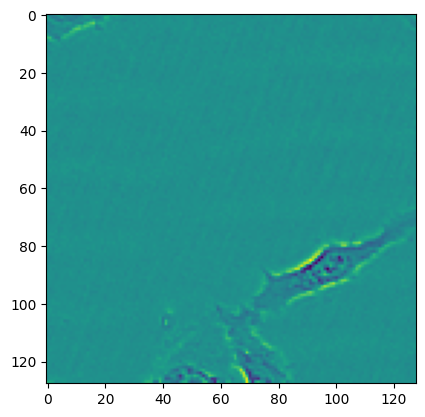

In [32]:
plt.imshow(X_test[0])